In [1]:
import gym
import gridworlds
import numpy as np
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib
import matplotlib.pyplot as plt

In [2]:
class StateConverter(object):
    def __init__(self, m, n):        
        self.current_id = 0
        self.state_to_id = {}
        self.id_to_state = {}
        
        for state in np.indices((m, n)).transpose(1, 2, 0).reshape(-1, 2):
            state_id = self.current_id
            self.state_to_id[tuple(state)] = state_id
            self.id_to_state[state_id] = state
            self.current_id += 1

    def get_id(self, state):
        state_id = self.state_to_id.get(state)
        
        if state_id is None:
            raise ValueError(f'No state_id set for the state: {state}')
        
        return state_id

    def get_state(self, state_id):
        return tuple(self.id_to_state.get(state_id))

class QLearning(object):
    def __init__(self, env, epsilon, alpha, gamma, decay_factor, render=False):
        self.env = env
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.decay_factor = decay_factor
        self.render = render
        
        self.Q = np.zeros([env.env.observation_space.n, env.env.action_space.n])
        self.state_converter = StateConverter(env.env.height, env.env.width)      # creates mapping from states to ids
        
    def epsilon_greedy(self, state):
        p = np.random.uniform()
        
        if p <= 1-self.epsilon:
            # choose optimal action
            state_id = self.state_converter.get_id(state)
            actions = self.Q[state_id,:]
            return np.random.choice(np.flatnonzero(actions == actions.max()))
            
        else:
            # choose random between actions
            return env.env.action_space.sample()
        
    def update_Q(self, state, action, suc_state, reward):
        # get ids and action-values
        state_id = self.state_converter.get_id(state)
        suc_state_id = self.state_converter.get_id(suc_state)
        max_q_suc = np.max(self.Q[suc_state_id, :])
        current_q = self.Q[state_id, action]
        
        # update action-value according to Q-learning
        self.Q[state_id, action] = current_q + self.alpha * (reward + self.gamma * max_q_suc - current_q)

        
    def train_agent(self, episodes, timesteps):
        steps = np.zeros(episodes)
        
        for episode in range(episodes):
            state = self.env.reset()
                        
            for t in range(timesteps):
                if self.render == True: self.env.render()
                action = self.epsilon_greedy(state)        
                suc_state, reward, done, _ = self.env.step(action)
                
                self.update_Q(state, action, suc_state, reward)
                state = suc_state
                
                if done:
                    steps[episode] = t+1    # starts at 0
                    break
            
            if self.epsilon >= 0.0005:
                self.epsilon -= self.decay_factor            
            
            if episode%50 == 0 and episode != 0:
                print(f'[INFO] - Q-table after episode {episode}.')
                self.plot_q()
                
        if self.render == True: env.close() 
            
        print(f'[INFO] - Finished training with epsisode: {episode}.')
        self.plot_q()
        self.plot_steps(steps)

        return self.Q
    
    def plot_q(self):
        action_dict = {0: "UP", 1: "RIGHT", 2: "DOWN", 3: "LEFT"}
        y_labels = [str(q_learning.state_converter.get_state(i)) for i in range(12)]
        y_labels[0] = "Start"
        y_labels[-1] = "Terminal"

        ax = sns.heatmap(self.Q, vmin=np.min(self.Q), vmax=np.max(self.Q), linewidths=.5, annot=True, fmt='.4f')
        ax.set_yticklabels(y_labels, rotation=0)
        ax.set_xticklabels([action_dict[x] for x in range(4)])
        plt.show()
    
    def plot_steps(self, steps):
        fig, ax = plt.subplots()
        ax.plot(steps)
        ax.set(xlabel='Episode', ylabel='Steps', title='Amount of steps taken by the Agent during training')

        plt.show()

In [3]:
env = gym.make('gridworld-v0')

q_learning = QLearning(env,
                       alpha=0.2,      # learning rate
                       epsilon=0.3,    # epsilon_greedy
                       gamma=0.85,      # discount factor (0-myopic; 1-far sighted)
                       decay_factor=0.0005,
                       render=False)
                       
print(f'The environment has {env.env.observation_space.n} states and {env.env.action_space.n} actions, with an state space of {env.env.observation_space} and an action space of {env.env.action_space}.')

The environment has 12 states and 4 actions, with an state space of Discrete(12) and an action space of Discrete(4).


[INFO] - Q-table after episode 50.


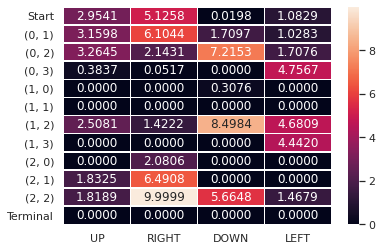

[INFO] - Q-table after episode 100.


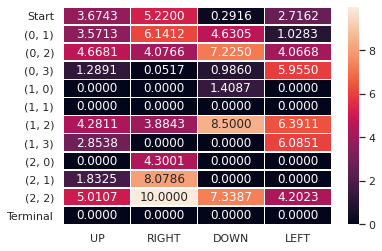

[INFO] - Q-table after episode 150.


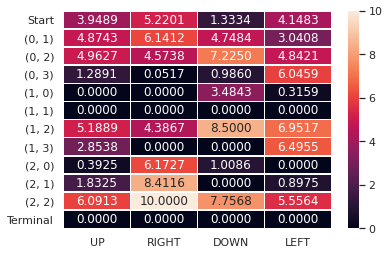

[INFO] - Q-table after episode 200.


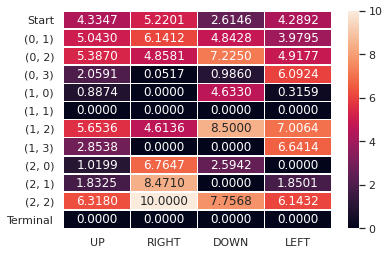

[INFO] - Q-table after episode 250.


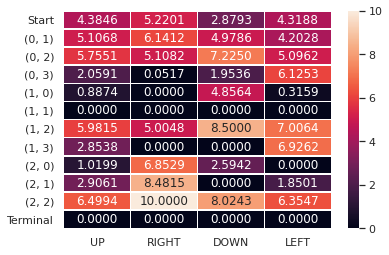

[INFO] - Q-table after episode 300.


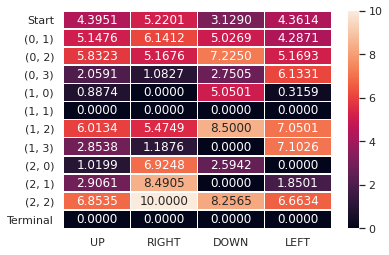

[INFO] - Q-table after episode 350.


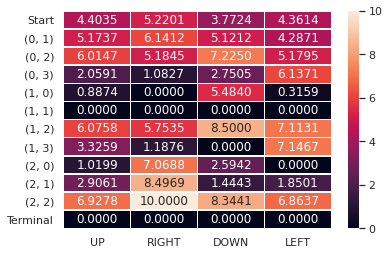

[INFO] - Q-table after episode 400.


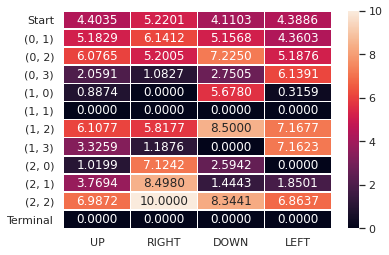

[INFO] - Q-table after episode 450.


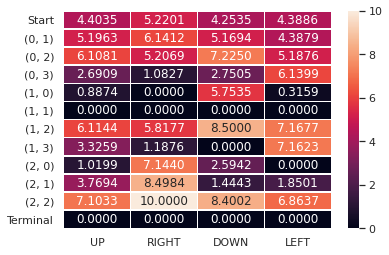

[INFO] - Finished training with epsisode: 499.


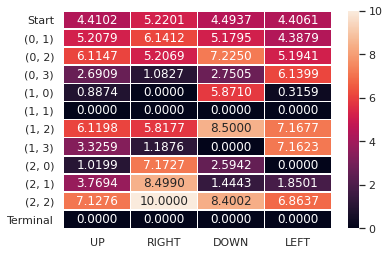

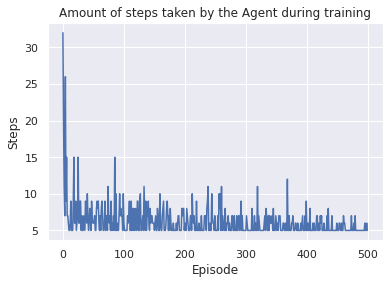

In [4]:
v_star = q_learning.train_agent(episodes=500,
                                timesteps=100)